本文件是第二版本的特征文件，从另一个角度针对表进行建模和 更高效的实验效果记录

In [16]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from itertools import product
import ast

In [17]:
path = 'E:/Machine-learning/kdd_cup_2019/data/'
data=pd.read_csv(path + '/feature_692434.csv', parse_dates=['req_time','plan_time','click_time'])

In [4]:
print(data.columns.values)

['Unnamed: 0' 'click_mode' 'click_time' 'd' 'o' 'pid' 'plan_time' 'plans'
 'req_time' 'sid' 'p0' 'p1' 'p2' 'p3' 'p4' 'p5' 'p6' 'p7' 'p8' 'p9' 'p10'
 'p11' 'p12' 'p13' 'p14' 'p15' 'p16' 'p17' 'p18' 'p19' 'p20' 'p21' 'p22'
 'p23' 'p24' 'p25' 'p26' 'p27' 'p28' 'p29' 'p30' 'p31' 'p32' 'p33' 'p34'
 'p35' 'p36' 'p37' 'p38' 'p39' 'p40' 'p41' 'p42' 'p43' 'p44' 'p45' 'p46'
 'p47' 'p48' 'p49' 'p50' 'p51' 'p52' 'p53' 'p54' 'p55' 'p56' 'p57' 'p58'
 'p59' 'p60' 'p61' 'p62' 'p63' 'p64' 'p65' 'o_lng' 'o_lat' 'd_lng' 'd_lat'
 'od_manhattan_distance' 'od_manhattan_distance_detail'
 'o_main_centroid_mean_dis' 'd_main_centroid_mean_dis'
 'o_main_centroid_mode_dis' 'd_main_centroid_mode_dis' 'o_nearest_dis'
 'd_nearest_dis' 'req_time_hour' 'req_time_weekday' 'req_time_minute'
 'time_diff' 'holiday_flag_0' 'holiday_flag_1' 'holiday_flag_3'
 'svd_fea_0' 'svd_fea_1' 'svd_fea_2' 'svd_fea_3' 'svd_fea_4' 'svd_fea_5'
 'svd_fea_6' 'svd_fea_7' 'svd_fea_8' 'svd_fea_9' 'svd_fea_10' 'svd_fea_11'
 'svd_fea_12' 'svd_fe

,Unnamed: 0,click_mode,click_time,d,o,pid,plan_time,plans,req_time,sid,...,diff_6_cloc_rank_buguiyi,o_appear_count,d_appear_count,diff_12_clock_rank_buguiyi,diff_18_clock_rank_buguiyi,diff_24_clock_rank_buguiyi,o_label_encoder_all,d_label_encoder_all,o_nearest_subway_datail,d_nearest_subway_datail
0,0,9.0,2018-11-02 17:54:32,"116.32,39.96","116.29,39.97",NaN,2018-11-02 17:54:30,"[{""distance"": 5219, ""price"": 300, ""eta"": 1367,...",2018-11-02 17:54:30,3000821,...,457577.5,1101,1046,441384.0,7464.0,136781.5,2266,2488,521.247074,337.641325
1,1,1.0,2018-11-16 10:53:32,"116.33,39.79","116.39,39.84",210736.0,2018-11-16 10:53:10,"[{""distance"": 13864, ""price"": 600, ""eta"": 3221...",2018-11-16 10:53:10,3085857,...,155371.5,695,185,92186.0,433662.0,433662.0,2996,2547,1705.782114,6183.612653
2,2,9.0,2018-10-06 10:34:23,"116.27,40.00","116.31,39.93",NaN,2018-10-06 10:33:58,"[{""distance"": 12294, ""price"": 400, ""eta"": 2472...",2018-10-06 10:33:58,2944522,...,141794.5,635,4633,118720.0,446389.0,446389.0,2409,2122,1958.393125,554.016010
3,3,1.0,2018-11-23 14:54:18,"116.39,39.90","116.27,39.88",202427.0,2018-11-23 14:54:11,"[{""distance"": 14853, ""price"": 1700, ""eta"": 291...",2018-11-23 14:54:11,559931,...,328837.0,363,8756,239577.5,220989.0,265522.0,2110,3002,3076.165073,504.259606
4,4,7.0,2018-10-30 11:49:04,"116.37,39.86","116.34,39.96",172251.0,2018-10-30 11:48:41,"[{""distance"": 12882, ""price"": 600, ""eta"": 3211...",2018-10-30 11:48:41,2819352,...,196835.0,1166,15545,15241.0,396292.5,396292.5,2642,2854,851.957106,751.656240
5,5,1.0,2018-10-18 07:38:25,"116.48,39.76","116.54,39.73",135606.0,2018-10-18 07:37:32,"[{""distance"": 8217, ""price"": """", ""eta"": 1743, ...",2018-10-18 07:37:32,2754575,...,29762.5,55,75,351156.5,554602.0,554602.0,4007,3611,16170.257311,10668.278197
6,6,1.0,2018-11-20 14:34:48,"116.79,40.35","116.34,39.73",189023.0,2018-11-20 14:34:03,"[{""distance"": 99097, ""price"": """", ""eta"": 6596,...",2018-11-20 14:34:03,2224795,...,314668.5,312,12,212212.0,242284.0,279690.5,2619,5691,12076.278862,43679.829477
7,7,1.0,2018-10-03 09:19:55,"116.24,40.22","116.26,40.22",156954.0,2018-10-03 09:19:47,"[{""distance"": 1484, ""price"": 200, ""eta"": 881, ...",2018-10-03 09:19:47,1598541,...,90237.5,350,745,220444.5,495883.0,495883.0,2067,1924,17365.176602,17936.179042
8,8,5.0,2018-11-15 15:25:55,"116.39,39.90","116.39,39.91",135045.0,2018-11-15 15:25:52,"[{""distance"": 1511, ""price"": """", ""eta"": 1294, ...",2018-11-15 15:25:52,676316,...,351149.0,3473,8756,281822.0,187143.0,243210.0,3003,3002,317.054192,504.259606
9,9,3.0,2018-11-08 23:14:06,"116.27,39.95","116.29,40.02",176605.0,2018-11-08 23:13:57,"[{""distance"": 10278, ""price"": """", ""eta"": 790, ...",2018-11-08 23:13:57,1068802,...,587797.0,114,513,583743.5,349949.5,6562.0,2271,2117,1919.903446,3319.217121


In [6]:
data

,Unnamed: 0,click_mode,click_time,d,o,pid,plan_time,plans,req_time,sid,...,od_couple_rank,od_couple_rank_buguiyi,diff_6_cloc_rank_buguiyi,o_appear_count,d_appear_count,diff_12_clock_rank_buguiyi,diff_18_clock_rank_buguiyi,diff_24_clock_rank_buguiyi,o_label_encoder_all,d_label_encoder_all
0,0,9.0,2018-11-02 17:54:32,"116.32,39.96","116.29,39.97",NaN,2018-11-02 17:54:30,"[{""distance"": 5219, ""price"": 300, ""eta"": 1367,...",2018-11-02 17:54:30,3000821,...,0.539242,320502.5,457577.5,1101,1046,441384.0,7464.0,136781.5,2266,2488
1,1,1.0,2018-11-16 10:53:32,"116.33,39.79","116.39,39.84",210736.0,2018-11-16 10:53:10,"[{""distance"": 13864, ""price"": 600, ""eta"": 3221...",2018-11-16 10:53:10,3085857,...,0.142254,84550.0,155371.5,695,185,92186.0,433662.0,433662.0,2996,2547
2,2,9.0,2018-10-06 10:34:23,"116.27,40.00","116.31,39.93",NaN,2018-10-06 10:33:58,"[{""distance"": 12294, ""price"": 400, ""eta"": 2472...",2018-10-06 10:33:58,2944522,...,0.589481,350362.5,141794.5,635,4633,118720.0,446389.0,446389.0,2409,2122
3,3,1.0,2018-11-23 14:54:18,"116.39,39.90","116.27,39.88",202427.0,2018-11-23 14:54:11,"[{""distance"": 14853, ""price"": 1700, ""eta"": 291...",2018-11-23 14:54:11,559931,...,0.700542,416373.0,328837.0,363,8756,239577.5,220989.0,265522.0,2110,3002
4,4,7.0,2018-10-30 11:49:04,"116.37,39.86","116.34,39.96",172251.0,2018-10-30 11:48:41,"[{""distance"": 12882, ""price"": 600, ""eta"": 3211...",2018-10-30 11:48:41,2819352,...,0.895537,532269.5,196835.0,1166,15545,15241.0,396292.5,396292.5,2642,2854
5,5,1.0,2018-10-18 07:38:25,"116.48,39.76","116.54,39.73",135606.0,2018-10-18 07:37:32,"[{""distance"": 8217, ""price"": """", ""eta"": 1743, ...",2018-10-18 07:37:32,2754575,...,0.142254,84550.0,29762.5,55,75,351156.5,554602.0,554602.0,4007,3611
6,6,1.0,2018-11-20 14:34:48,"116.79,40.35","116.34,39.73",189023.0,2018-11-20 14:34:03,"[{""distance"": 99097, ""price"": """", ""eta"": 6596,...",2018-11-20 14:34:03,2224795,...,0.142254,84550.0,314668.5,312,12,212212.0,242284.0,279690.5,2619,5691
7,7,1.0,2018-10-03 09:19:55,"116.24,40.22","116.26,40.22",156954.0,2018-10-03 09:19:47,"[{""distance"": 1484, ""price"": 200, ""eta"": 881, ...",2018-10-03 09:19:47,1598541,...,0.870922,517639.5,90237.5,350,745,220444.5,495883.0,495883.0,2067,1924
8,8,5.0,2018-11-15 15:25:55,"116.39,39.90","116.39,39.91",135045.0,2018-11-15 15:25:52,"[{""distance"": 1511, ""price"": """", ""eta"": 1294, ...",2018-11-15 15:25:52,676316,...,0.971595,577475.5,351149.0,3473,8756,281822.0,187143.0,243210.0,3003,3002
9,9,3.0,2018-11-08 23:14:06,"116.27,39.95","116.29,40.02",176605.0,2018-11-08 23:13:57,"[{""distance"": 10278, ""price"": """", ""eta"": 790, ...",2018-11-08 23:13:57,1068802,...,0.142254,84550.0,587797.0,114,513,583743.5,349949.5,6562.0,2271,2117


# 位置特征

#### 与最近地铁站的haversine距离

In [4]:
subway_distance_datail=pd.read_csv(path + '/feature_data/subway_distance_datail.csv',index_col=0)
subway_distance_datail


,o_nearest_subway_datail,d_nearest_subway_datail
0,521.247074,337.641325
1,1705.782114,6183.612653
2,1958.393125,554.016010
3,3076.165073,504.259606
4,851.957106,751.656240
5,16170.257311,10668.278197
6,12076.278862,43679.829477
7,17365.176602,17936.179042
8,317.054192,504.259606
9,1919.903446,3319.217121


In [7]:
data=pd.concat((data,subway_distance_datail),axis=1)

#### 多种对起点终点距离的计算方式

In [19]:

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h * 1000


def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return (a + b)*1000


def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

data['haversine_dist'] = data.apply(lambda row:haversine_array(row['o_lat'], row['o_lng'], row['d_lat'], row['d_lng']), axis=1)
data['od_manhattan_dist'] = data.apply(lambda row:dummy_manhattan_distance(row['o_lat'], row['o_lng'], row['d_lat'], row['d_lng']), axis=1)
data['bearing'] = data.apply(lambda row:bearing_array(row['o_lat'], row['o_lng'], row['d_lat'], row['d_lng']), axis=1)

data['center1'] = (data['o_lat']+data['o_lng'])/2
data['center2'] = (data['d_lat']+data['d_lng'])/2




#### 位置信息聚类
首先对起点位置进行下11类的聚类

In [8]:
from sklearn.cluster import KMeans
coords = np.vstack((data[['o_lat', 'o_lng']].values,
                    data[['d_lat', 'd_lng']].values))

sample_ind = np.random.permutation(len(coords))
kmeans = KMeans(n_clusters=11).fit(coords[sample_ind])

data.loc[:, 'o_kmeans'] = kmeans.predict(data[['o_lat', 'o_lng']])
data.loc[:, 'd_kmeans'] = kmeans.predict(data[['d_lat', 'd_lng']])

0         1
1         8
2         1
3         1
4         9
5         7
6         3
7         2
8         8
9         9
10        0
11        0
12        9
13        8
14        9
15        1
16        2
17        8
18        8
19        9
20        1
21        1
22        0
23        3
24        9
25        9
26        9
27        8
28        9
29        8
         ..
594328    0
594329    0
594330    2
594331    1
594332    9
594333    8
594334    8
594335    0
594336    1
594337    8
594338    5
594339    0
594340    8
594341    1
594342    9
594343    9
594344    6
594345    0
594346    0
594347    0
594348    0
594349    0
594350    1
594351    8
594352    8
594353    3
594354    3
594355    1
594356    9
594357    8
Name: o_kmeans, Length: 594358, dtype: int32


# 时间特征

#### 用户在不同时间点发起请求的 统计 

In [52]:
temp=data[['pid','req_time_hour']].groupby(['pid'])['req_time_hour'].value_counts().unstack(fill_value=0)
temp.columns = ['click_hour_count' + str(num) for num in range(24)]
temp
data=data.merge(temp, on='pid', how='left')

#### 因为发现距离不同时间点距离的重要性，所以现在把时间距离进行精细化
之前已经添加了6,12,18,24

In [62]:
def diff_6_clock(time_point,hour):
    t12_clock=str(time_point.year)+'-'+str(time_point.month)+'-'+str(time_point.day)+' '+str(hour)+':0:00'
    t12_clock=pd.to_datetime(t12_clock)
    the_diff=(t12_clock- time_point).total_seconds()
    return the_diff/60

data['diff_8_cloc']=data['req_time'].apply(diff_6_clock,args = (8,))
print('----  提取结束  ----')
data['diff_9_cloc']=data['req_time'].apply(diff_6_clock,args = (9,))
print('----  提取结束  ----')
data['diff_10_cloc']=data['req_time'].apply(diff_6_clock,args = (10,))
print('----  提取结束  ----')
data['diff_19_cloc']=data['req_time'].apply(diff_6_clock,args = (19,))
print('----  提取结束  ----')
data['diff_20_cloc']=data['req_time'].apply(diff_6_clock,args = (20,))
print('----  提取结束  ----')
data['diff_22_cloc']=data['req_time'].apply(diff_6_clock,args = (22,))
print('----  提取结束  ----')
data['diff_23_cloc']=data['req_time'].apply(diff_6_clock,args = (23,))
print('----  提取结束  ----')

----  提取结束  ----
----  提取结束  ----
----  提取结束  ----
----  提取结束  ----
----  提取结束  ----
----  提取结束  ----
----  提取结束  ----


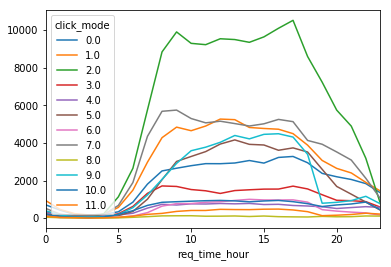

In [64]:
#画图展示，不同小时的角度方式选择的情况
pd.crosstab(data['req_time_hour'],data['click_mode']).plot()


图像上可以得知，不同小时上 的  交通模式还是比较有区分度的，有一定的规律，不断产生，这也就解释了 时间特征的作用意义了


In [9]:
#根据画图，对时间做三个阶段的分箱操作
def gen_hour_box(req_time_hour):
    if 0<=req_time_hour<9:
        return 0
    if 9<=req_time_hour<18:
        return 1
    if 19<=req_time_hour<24:
        return 3

hour=data[['pid','req_time_hour']]
print(hour)
data['req_time_hour_box']=hour.apply(lambda row:gen_hour_box(row['req_time_hour']),axis=1)

             pid  req_time_hour
0            NaN             17
1       210736.0             10
2            NaN             10
3       202427.0             14
4       172251.0             11
5       135606.0              7
6       189023.0             14
7       156954.0              9
8       135045.0             15
9       176605.0             23
10           NaN              1
11      207329.0             16
12           NaN             13
13      215847.0             10
14           NaN             12
15           NaN              9
16      207363.0             13
17      144649.0              9
18      116986.0             13
19      180421.0             15
20           NaN              9
21      175212.0             14
22      112198.0             21
23      135562.0             14
24      202757.0             16
25      200008.0             11
26      112198.0             13
27      211790.0             17
28      116844.0             13
29           NaN              8
...     

In [43]:
#每个小时 出现请求次数的统计
temp=data.groupby('req_time_hour')['sid'].agg({'req_time_hour_count':'count'})
temp
data=data.merge(temp, on='req_time_hour', how='left')

data.columns.values
#pd.crosstab(data['hour_apper_count'],data['click_mode']).plot()

array(['Unnamed: 0', 'click_mode', 'click_time', 'd', 'o', 'pid',
       'plan_time', 'plans', 'req_time', 'sid', 'p0', 'p1', 'p2', 'p3',
       'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13',
       'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22',
       'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31',
       'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40',
       'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49',
       'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58',
       'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'o_lng', 'o_lat',
       'd_lng', 'd_lat', 'od_manhattan_distance',
       'od_manhattan_distance_detail', 'o_main_centroid_mean_dis',
       'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis',
       'd_main_centroid_mode_dis', 'o_nearest_dis', 'd_nearest_dis',
       'req_time_hour', 'req_time_weekday', 'req_time_minute',
       'time_diff', 'holiday_flag_0', 'holiday_flag_1',

In [41]:
data['req_time_hour_count']

KeyError: 'req_time_hour_count'

# plan导航特征

#### 获取提供给每个pid中的价钱最大最小值的差距
直接交叉获取所有的情况

In [5]:
from pandas import DataFrame as DF
def get_division_feature(data ,feature_name):
    # 创造出特征之间 进行四则变换的特征， 每两两特征之间进行变化，  并且进行变换之后把变化后的 新特证名记录下来，（知道了吧。不想之前直接一起，
    # 特征名都完全丢失了
    new_feature = []
    new_feature_name = []
    for i in tqdm(range(len(data[feature_name].columns ) -1)):
        for j in range( i +1 ,len(data[feature_name].columns)):
            # 保存新创建的特征值和特征名
            new_feature_name.append(data[feature_name].columns[i] + '/' + data[feature_name].columns[j])
            new_feature_name.append(data[feature_name].columns[i] + '*' + data[feature_name].columns[j])
            new_feature_name.append(data[feature_name].columns[i] + '+' + data[feature_name].columns[j])
            new_feature_name.append(data[feature_name].columns[i] + '-' + data[feature_name].columns[j])
            new_feature.append(data[data[feature_name].columns[i] ] /data[data[feature_name].columns[j]])
            new_feature.append(data[data[feature_name].columns[i] ] *data[data[feature_name].columns[j]])
            new_feature.append(data[data[feature_name].columns[i] ] +data[data[feature_name].columns[j]])
            new_feature.append(data[data[feature_name].columns[i] ] -data[data[feature_name].columns[j]])


    temp_data = DF(pd.concat(new_feature ,axis=1))
    temp_data.columns = new_feature_name
    data = pd.concat([data ,temp_data] ,axis=1).reset_index(drop=True)

    print(data.shape)

    return data.reset_index(drop=True)


jiaocha_data = get_division_feature(data[['max_dist','min_dist','mean_dist','std_dist','max_price','min_price','mean_price','max_eta','min_eta','mean_eta']],['max_dist','min_dist','mean_dist','std_dist','max_price','min_price','mean_price','max_eta','min_eta','mean_eta'])


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.17s/it]


(594358, 190)


In [12]:
#jiaocha_data=jiaocha_data.drop(['max_dist','min_dist','mean_dist','std_dist','max_price','min_price','mean_price','max_eta','min_eta','mean_eta'],axis=1)
#jiaocha_data.shape
#data=pd.concat((data,jiaocha_data),axis=1)
data.shape

(594358, 508)

In [15]:
jiaocha_data_name=list(jiaocha_data.columns.values)

####  统计按照不同起点和终点情况的mode点击情况  (分组与)


In [8]:

#   统计不同起点的点击情况


col = 'o'
temp = data[[col,'click_mode']].groupby([col])['click_mode'].value_counts().unstack(fill_value=0)
temp.columns = [col+'_'+'mode_count_' + str(num) for num in range(12)]
data=data.merge(temp, on=col, how='left')
#train_x = train_x.merge(temp, on=col, how='left')
#valid_x = valid_x.merge(temp, on=col, how='left')

In [9]:
data.columns.values

array(['Unnamed: 0', 'click_mode', 'click_time', 'd', 'o', 'pid',
       'plan_time', 'plans', 'req_time', 'sid', 'p0', 'p1', 'p2', 'p3',
       'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13',
       'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22',
       'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31',
       'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40',
       'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49',
       'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58',
       'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'o_lng', 'o_lat',
       'd_lng', 'd_lat', 'od_manhattan_distance',
       'od_manhattan_distance_detail', 'o_main_centroid_mean_dis',
       'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis',
       'd_main_centroid_mode_dis', 'o_nearest_dis', 'd_nearest_dis',
       'req_time_hour', 'req_time_weekday', 'req_time_minute',
       'time_diff', 'holiday_flag_0', 'holiday_flag_1',

# 用户表征特征

#### 用户以往使用不同mode、不同模态的计数（记住只是用训练集上除了本行的进行统计，  不可以用到验证集上的标签，妥妥的穿越了..）

In [17]:
print('————————      获取每个sid平展      ——————————')

data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
train_index = (data.req_time < '2018-12-01')
train     = data[train_index].reset_index(drop=True)

plans = np.dstack((np.repeat(train['sid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['pid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['click_mode'].values,list(map(len,train['plans_json'].values))),np.concatenate(train['plans_json'].values)))
plans = pd.DataFrame(plans[0],columns=['sid','pid','click_mode','plans'])
plans = pd.concat([plans, pd.DataFrame.from_dict(plans['plans'].tolist())], axis=1)

————————      获取每个sid平展      ——————————


In [18]:
print(plans)

             sid     pid click_mode  \
0        3000821     NaN          9   
1        3000821     NaN          9   
2        3000821     NaN          9   
3        3000821     NaN          9   
4        3000821     NaN          9   
5        3000821     NaN          9   
6        3085857  210736          1   
7        3085857  210736          1   
8        3085857  210736          1   
9        3085857  210736          1   
10       3085857  210736          1   
11       2944522     NaN          9   
12       2944522     NaN          9   
13       2944522     NaN          9   
14       2944522     NaN          9   
15       2944522     NaN          9   
16       2944522     NaN          9   
17       2944522     NaN          9   
18        559931  202427          1   
19        559931  202427          1   
20        559931  202427          1   
21        559931  202427          1   
22        559931  202427          1   
23       2819352  172251          7   
24       2819352  172251 

[2276822 rows x 8 columns]


385it [06:21,  1.00s/it]

KeyboardInterrupt: 

In [22]:
from multiprocessing import Pool
from multiprocessing import cpu_count
processor=cpu_count()-2

In [ ]:
#重构的代码   (效率提升了30倍)       只用子集去构建，真的内存很容易爆炸    数据穿越了,这里是使用训练集中的数据做统计吧
#data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
data_a=data[data.req_time < '2018-11-23']
data_a=data_a[['sid','pid','click_mode']]
data_b=data[['sid','pid','click_mode']]
def  run_get_pid_mode_count_feature(data_a):
    features=[]
    
    print(len(data_a))
    for i, row in data_a.iterrows():
        #print(i)
        #抽取除当前行的所有行
        the_other_data_row=data_a[data_a['sid']!=row['sid']]
        feature={}
        use_get_CVR_plans_rows=the_other_data_row[the_other_data_row['pid']==row['pid']]
        
        pid_mode_0_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==0)])
        pid_mode_1_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==1)])
        pid_mode_2_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==2)])    
        pid_mode_3_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==3)]) 
        pid_mode_4_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==4)]) 
        pid_mode_5_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==5)]) 
        pid_mode_6_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==6)]) 
        pid_mode_7_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==7)]) 
        pid_mode_8_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==8)]) 
        pid_mode_9_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==9)]) 
        pid_mode_10_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==10)]) 
        pid_mode_11_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==11)]) 
        
        feature['pid_mode_0_count']=pid_mode_0_count
        feature['pid_mode_1_count']=pid_mode_1_count
        feature['pid_mode_2_count']=pid_mode_2_count
        feature['pid_mode_3_count']=pid_mode_3_count
        feature['pid_mode_4_count']=pid_mode_4_count
        feature['pid_mode_5_count']=pid_mode_5_count
        feature['pid_mode_6_count']=pid_mode_6_count
        feature['pid_mode_7_count']=pid_mode_7_count
        feature['pid_mode_8_count']=pid_mode_8_count
        feature['pid_mode_9_count']=pid_mode_9_count
        feature['pid_mode_10_count']=pid_mode_10_count
        feature['pid_mode_11_count']=pid_mode_11_count
        
        features.append(feature)
    features=pd.DataFrame(features)
    return features


def get_pid_mode_count_feature(data_a):
    #并行化执行对训练集的统计函数    这里用6个核心进行并行化处理，来加速计算      并行有问题，慢的一比 跑不出效果来
    res = []
    p = Pool(processor)
    df_parts=np.array_split(data_a,6)  
    
    for i in range(processor):
        res.append(p.apply_async(run_get_pid_mode_count_feature, args=(df_parts[i])))
        print(str(i) + ' processor started !')
    p.close()
    p.join()

    data=pd.concat([i.get() for i in res])
    
    data.to_csv(path + '/feature_data/pid_mode_count_feature.csv',index=False)
    

pid_mode_count_feature=get_pid_mode_count_feature(data_a)


In [ ]:
#这个代码时比较简单但慢的实现形式

data_a=data[data.req_time < '2018-11-23']
data_a=data_a[['sid','pid','click_mode']]
data_b=data[['sid','pid','click_mode']]
def  run_get_pid_mode_count_feature(data_a,data_b):
    features=[]

    for i, row in tqdm(data_b.iterrows()):
        #print(i)
        #抽取除当前行的所有行
        the_other_data_row=data_a[data_a['sid']!=row['sid']]
        feature={}
        use_get_CVR_plans_rows=the_other_data_row[the_other_data_row['pid']==row['pid']]
        
        pid_mode_0_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==0)])
        pid_mode_1_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==1)])
        pid_mode_2_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==2)])    
        pid_mode_3_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==3)]) 
        pid_mode_4_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==4)]) 
        pid_mode_5_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==5)]) 
        pid_mode_6_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==6)]) 
        pid_mode_7_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==7)]) 
        pid_mode_8_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==8)]) 
        pid_mode_9_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==9)]) 
        pid_mode_10_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==10)]) 
        pid_mode_11_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==11)])        
        feature['pid_mode_0_count']=pid_mode_0_count
        feature['pid_mode_1_count']=pid_mode_1_count
        feature['pid_mode_2_count']=pid_mode_2_count
        feature['pid_mode_3_count']=pid_mode_3_count
        feature['pid_mode_4_count']=pid_mode_4_count
        feature['pid_mode_5_count']=pid_mode_5_count
        feature['pid_mode_6_count']=pid_mode_6_count
        feature['pid_mode_7_count']=pid_mode_7_count
        feature['pid_mode_8_count']=pid_mode_8_count
        feature['pid_mode_9_count']=pid_mode_9_count
        feature['pid_mode_10_count']=pid_mode_10_count
        feature['pid_mode_11_count']=pid_mode_11_count
        
        features.append(feature)
    features=pd.DataFrame(features)
    return features

pid_mode_count_feature=run_get_pid_mode_count_feature(data_a,data_b)
pid_mode_count_feature.to_csv(path + '/feature_data/pid_mode_count_feature1.csv',index=False)



In [14]:
print(pid_mode_count_feature['pid_mode_1_count'])

pid_mode_0_count
0        0
0        0
0        0
83     254
1        0
1        5
3       21
0        1
28      82
2        4
0        0
4        6
0        0
0        2
0        0
0        0
0        2
4       29
0        0
15      46
0        0
0        0
265    602
0        1
47     120
8       25
265    602
0        0
153    411
0        0
      ... 
0        0
0        0
6       19
7        5
0        0
0        2
0        0
0        0
12      23
0        0
0        0
0        0
0        0
0        0
0        0
0        0
0        3
0        0
0        0
11      33
130    327
0        1
0        0
1        0
0        0
0        0
0        0
3       15
0        0
0        0
Name: pid_mode_1_count, Length: 594358, dtype: int64


In [3]:
#读取 mode点击次数的统计,  所标签部分统计出来的，  这个名字感觉有些误导
pid_mode_count_feature=pd.read_csv(path + '/feature_data/pid_mode_count_feature1.csv')
print(pid_mode_count_feature.shape)
print(data.shape)
print(pid_mode_count_feature.columns)
data=pd.concat((data,pid_mode_count_feature),axis=1)

(594358, 12)
(594358, 328)
Index(['pid_mode_0_count', 'pid_mode_10_count', 'pid_mode_11_count',
       'pid_mode_1_count', 'pid_mode_2_count', 'pid_mode_3_count',
       'pid_mode_4_count', 'pid_mode_5_count', 'pid_mode_6_count',
       'pid_mode_7_count', 'pid_mode_8_count', 'pid_mode_9_count'],
      dtype='object')


In [21]:
pid_mode_count_feature

,pid_mode_0_count,pid_mode_10_count,pid_mode_11_count,pid_mode_1_count,pid_mode_2_count,pid_mode_3_count,pid_mode_4_count,pid_mode_5_count,pid_mode_6_count,pid_mode_7_count,pid_mode_8_count,pid_mode_9_count
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,83,35,25,254,487,28,26,190,46,314,9,170
4,1,0,0,0,3,1,0,1,1,0,0,1
5,1,1,1,5,2,1,0,1,0,2,0,0
6,3,3,0,21,30,0,0,0,0,9,0,4
7,0,0,0,1,3,0,0,0,2,0,0,2
8,28,22,4,82,182,14,13,44,14,82,2,57
9,2,0,0,4,0,1,0,2,3,2,0,0


#### 统计用户的plans中出现不同mode的计数
这个直接统建不同pid下，transport_mode出现次数的统计

In [9]:
print('————————      获取每个sid平展并计数mode出现      ——————————')
def gen_click_mode_appear_count():
    data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
    train     = data.reset_index(drop=True)

    plans = np.dstack((np.repeat(train['sid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['pid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['click_mode'].values,list(map(len,train['plans_json'].values))),np.concatenate(train['plans_json'].values)))
    plans = pd.DataFrame(plans[0],columns=['sid','pid','click_mode','plans'])
    plans = pd.concat([plans, pd.DataFrame.from_dict(plans['plans'].tolist())], axis=1)


    temp=plans[['pid','transport_mode']].groupby(['pid'])['transport_mode'].value_counts().unstack(fill_value=0)
    print(temp)
    temp.columns = ['plan_mode_appear_' + str(num) for num in range(11)]

    train_x = data.merge(temp, on='pid', how='left')


    path = 'E:/Machine-learning/kdd_cup_2019/data/'
    
    #print(train_x.columns)
    #train_x[['plan_mode_appear_' + str(num) for num in range(11)]].to_csv(path + '/feature_data/plan_mode_appear_count.csv')
gen_click_mode_appear_count()

————————      获取每个sid平展并计数mode出现      ——————————
transport_mode   1    2    3    4    5    6    7   8    9    10  11
pid                                                                
100000.0          7    3    8    8    1    1    6   0    6    2   0
100002.0          1    1    1    1    0    1    0   0    0    0   0
100005.0         25   19   41   37   12   16   19   0    9   11   3
100006.0          0    3    5    3    3    4    1   0    1    0   0
100007.0          2    2    3    3    0    0    2   0    0    0   1
100010.0          2    0    2    2    0    0    2   1    0    1   0
100011.0        583  398  859  802  264  383  401  25  258  147  48
100012.0          1    0    1    1    0    0    0   1    0    0   0
100017.0          2    2    2    2    0    0    0   0    0    0   0
100018.0          2    0    2    2    0    0    2   0    2    1   0
100026.0          0    1    1    1    0    0    1   0    1    0   0
100030.0          1    0    1    1    0    0    1   0    0    0   1

KeyboardInterrupt: 

In [98]:
list(map(len,data['plans_json'].values))

[406,
 345,
 483,
 347,
 264,
 341,
 281,
 402,
 335,
 205,
 195,
 404,
 345,
 406,
 405,
 336,
 417,
 264,
 409,
 347,
 345,
 335,
 412,
 341,
 196,
 278,
 345,
 403,
 195,
 338,
 406,
 345,
 345,
 346,
 407,
 207,
 403,
 278,
 416,
 406,
 330,
 348,
 416,
 64,
 276,
 408,
 403,
 347,
 278,
 345,
 207,
 345,
 405,
 346,
 277,
 345,
 266,
 408,
 473,
 348,
 342,
 197,
 420,
 261,
 276,
 278,
 404,
 206,
 2,
 187,
 204,
 347,
 347,
 347,
 268,
 193,
 347,
 405,
 416,
 189,
 2,
 276,
 403,
 197,
 278,
 207,
 278,
 339,
 207,
 345,
 207,
 340,
 2,
 346,
 415,
 339,
 188,
 2,
 345,
 2,
 346,
 339,
 276,
 207,
 403,
 278,
 348,
 347,
 271,
 415,
 2,
 347,
 273,
 338,
 409,
 344,
 279,
 276,
 208,
 277,
 416,
 277,
 277,
 403,
 276,
 338,
 347,
 417,
 347,
 345,
 416,
 474,
 347,
 345,
 405,
 404,
 334,
 345,
 196,
 276,
 346,
 207,
 207,
 277,
 207,
 261,
 347,
 339,
 347,
 332,
 194,
 195,
 348,
 348,
 403,
 337,
 333,
 277,
 271,
 345,
 277,
 207,
 209,
 345,
 278,
 207,
 406,
 347,
 408,

In [4]:
#获取出现次数的统计
pid_mode_appear_plans_count=pd.read_csv(path + '/feature_data/plan_mode_appear_count.csv',index_col=0)
pid_mode_appear_plans_count.fillna(-1, inplace=True)
print(pid_mode_appear_plans_count.shape)
print(data.shape)
print(pid_mode_appear_plans_count.columns)
data=pd.concat((data,pid_mode_appear_plans_count),axis=1)

(594358, 11)
(594358, 340)
Index(['plan_mode_appear_0', 'plan_mode_appear_1', 'plan_mode_appear_2',
       'plan_mode_appear_3', 'plan_mode_appear_4', 'plan_mode_appear_5',
       'plan_mode_appear_6', 'plan_mode_appear_7', 'plan_mode_appear_8',
       'plan_mode_appear_9', 'plan_mode_appear_10'],
      dtype='object')


In [20]:
pid_mode_appear_plans_count

,plan_mode_appear_0,plan_mode_appear_1,plan_mode_appear_2,plan_mode_appear_3,plan_mode_appear_4,plan_mode_appear_5,plan_mode_appear_6,plan_mode_appear_7,plan_mode_appear_8,plan_mode_appear_9,plan_mode_appear_10
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1736.0,1073.0,2605.0,2356.0,770.0,1090.0,1278.0,123.0,645.0,476.0,125.0
4,12.0,6.0,15.0,13.0,2.0,7.0,7.0,0.0,6.0,0.0,1.0
5,29.0,11.0,27.0,27.0,5.0,11.0,11.0,1.0,11.0,3.0,1.0
6,43.0,33.0,74.0,72.0,13.0,24.0,36.0,2.0,15.0,20.0,1.0
7,8.0,6.0,10.0,9.0,4.0,5.0,0.0,0.0,3.0,2.0,1.0
8,493.0,352.0,709.0,658.0,200.0,302.0,361.0,22.0,205.0,134.0,35.0
9,22.0,9.0,24.0,22.0,11.0,17.0,7.0,0.0,7.0,2.0,1.0


####  统计下mode点击转换率，
这里是计算 点击次数/（出现次数+20）作为其特征，这样时刻使得次数更加稳固，越大说明可靠性越强

In [28]:
for i in range(1,12):
    data['transform_mode_'+str(i)+'_num']=data['pid_mode_'+str(i)+'_count']/(data['plan_mode_appear_'+str(i-1)]+3)

In [18]:
data[['o','d']]


,o,d
0,"116.29,39.97","116.32,39.96"
1,"116.39,39.84","116.33,39.79"
2,"116.31,39.93","116.27,40.00"
3,"116.27,39.88","116.39,39.90"
4,"116.34,39.96","116.37,39.86"
5,"116.54,39.73","116.48,39.76"
6,"116.34,39.73","116.79,40.35"
7,"116.26,40.22","116.24,40.22"
8,"116.39,39.91","116.39,39.90"
9,"116.29,40.02","116.27,39.95"


# 交叉特征

# 词向量特征

#### 添加经纬度-时间点标识

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

temp_data=data[['o','d','req_time_hour','pid']]


#
temp_data['od_label_encoder']=temp_data.apply(lambda row:(row['o']+'_'+row['d']),axis=1) 
le.fit(list(temp_data['od_label_encoder']))
data['od_label_encoder']=le.transform(list(temp_data['od_label_encoder']))

#
temp_data['od_hour_label_encoder']=temp_data.apply(lambda row:(row['o']+'_'+row['d']+'_'+str(row['req_time_hour'])),axis=1)
le.fit(list(temp_data['od_hour_label_encoder']))
data['od_hour_label_encoder']=le.transform(list(temp_data['od_hour_label_encoder']))

#
temp_data['pid_od_hour_encoder']=temp_data.apply(lambda row:(str(row['pid'])+'_'+row['o']+'_'+row['d']+'_'+str(row['req_time_hour'])),axis=1) 
le.fit(list(temp_data['pid_od_hour_encoder']))
data['pid_od_hour_label_encoder']=le.transform(list(temp_data['pid_od_hour_encoder']))



tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vec = tfidf_enc.fit_transform(temp_data['pid_od_hour_encoder'])
svd_enc = TruncatedSVD(n_components=6, n_iter=20, random_state=2019)
mode_svd = svd_enc.fit_transform(tfidf_vec)
mode_svd = pd.DataFrame(mode_svd)
mode_svd.columns = ['pid_od_hour_svd_{}'.format(i) for i in range(6)]

In [9]:
for i in range(6):
    data['pid_od_hour_svd_{}'.format(i)]=mode_svd['pid_od_hour_svd_{}'.format(i)]

In [12]:
data.columns.values

array(['Unnamed: 0', 'click_mode', 'click_time', 'd', 'o', 'pid',
       'plan_time', 'plans', 'req_time', 'sid', 'p0', 'p1', 'p2', 'p3',
       'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13',
       'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22',
       'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31',
       'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40',
       'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49',
       'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58',
       'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'o_lng', 'o_lat',
       'd_lng', 'd_lat', 'od_manhattan_distance',
       'od_manhattan_distance_detail', 'o_main_centroid_mean_dis',
       'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis',
       'd_main_centroid_mode_dis', 'o_nearest_dis', 'd_nearest_dis',
       'req_time_hour', 'req_time_weekday', 'req_time_minute',
       'time_diff', 'holiday_flag_0', 'holiday_flag_1',

# 训练和测试

In [18]:
def f1_weighted(labels,preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    #print('labels:',labels)
    #print('preds:',preds)    
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

#### 第一版本特征的加载

In [20]:
######################################   原始变换特征    ######################################
#data=new_df
#这里是自己组建需要使用的特征    baseline特征
plan_features      = ['mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4', 'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9']
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat']+profile_feature
cate_feature       = ['pid']  

     
#原始编码信息
#od_label_encod=['o_label_encoder_all','d_label_encoder_all']   #降分
                       # 平展特征

#pingzhan_rank_feature=['plan_model_'+str(i)+'_rank'  for i in range(1,12)]

#base_feature=[]+pingzhan_dist_feature+pingzhan_price_feature+pingzhan_eta_feature+pingzhan_rank_feature

pingzhan_dist_feature=['plan_model_'+str(i)+'_dist'  for i in range(1,12)]
pingzhan_price_feature=['plan_model_'+str(i)+'_price'  for i in range(1,12)]
#pingzhan_eta_feature=['plan_model_'+str(i)+'_eta'  for i in range(1,12)]
pingzhan_rank_feature=['plan_model_'+str(i)+'_rank'  for i in range(1,12)]


base_feature=pingzhan_dist_feature+pingzhan_price_feature+pingzhan_rank_feature
######################################   日期特征    ######################################
#日期特征添加 
#holiday_featur     = ['holiday_flag_0','holiday_flag_1','holiday_flag_3']
time_diff_feature=['time_diff']
time_clock_feat=['req_time_hour']

time_clock_diff=['diff_6_cloc','diff_12_clock','diff_18_clock','diff_24_clock']

time_jiaocha_detail=[]    #八成降分  去掉了


time_feature=time_diff_feature+time_clock_feat+time_clock_diff +time_jiaocha_detail
######################################   距离特征    ######################################
#距离特征添加         不加地铁提升两个万分点
subway_feature     = ['od_manhattan_distance','o_nearest_dis', 'd_nearest_dis']    #去掉了
#bus_distance_feature =  ['o_nearest_bus_dis','d_nearest_bus_dis']  #降分
distance_center_feature=['od_manhattan_distance_detail','o_main_centroid_mean_dis','d_main_centroid_mean_dis','o_main_centroid_mode_dis','d_main_centroid_mode_dis']




distance_feature=subway_feature+distance_center_feature
######################################   统计特征    ######################################
#统计特征添加
#pid_query_count=['pid_query_count']



statistics_feature=[]
######################################   排序特征    ######################################
#排序特征添加
#位置点出行情况排序
od_apper_rank=['o_appear_count', 'd_appear_count', 'o_appear_count_rank',
       'd_appear_count_rank','o_appear_count_rank_buguiyi', 'd_appear_count_rank_buguiyi']
od_couple_rank=['od_couple_count']

#对plan统计特征进行排序
#plan_jieshao_static_rank=['max_dist_rank','min_dist_rank','mean_dist_rank','std_dist_rank','max_price_rank','min_price_rank','mean_price_rank','std_price_rank','max_eta_rank','min_eta_rank','mean_eta_rank','std_eta_rank']    

#对自己平展方式效果的排序
pingzhan_dist_rank_feature=['plan_model_'+str(i)+'_dist_rank'  for i in range(1,12)]
pingzhan_price_rank_feature=['plan_model_'+str(i)+'_price_rank'  for i in range(1,12)]
pingzhan_eta_rank_feature=['plan_model_'+str(i)+'_eta_rank'  for i in range(1,12)]
pingzhan_rank_rank_feature=['plan_model_'+str(i)+'_rank_rank'  for i in range(1,12)]

plan_pingzhan_static_rank=pingzhan_dist_rank_feature+pingzhan_price_rank_feature+pingzhan_eta_rank_feature+pingzhan_rank_rank_feature

#对整点时间差进行rank
#time_diff_rank=['diff_6_cloc_rank_buguiyi','diff_12_clock_rank_buguiyi','diff_18_clock_rank_buguiyi','diff_24_clock_rank_buguiyi']



rank_feature=od_apper_rank+plan_pingzhan_static_rank +od_couple_rank
######################################   个人属性特征    ######################################


#个人属性信息添加
#prof_svd = ['svd_fea_{}'.format(i) for i in range(20)]
profile=[]
######################################   特征拼接    ######################################

#特征拼接
feature_version1            = origin_num_feature + cate_feature + plan_features + time_feature+distance_feature+profile+base_feature+rank_feature

#删除一部分  低重要度
feature_version1.remove('plan_model_6_price_rank')
feature_version1.remove('plan_model_5_price_rank')
feature_version1.remove('plan_model_5_price')
feature_version1.remove('plan_model_6_price')
feature_version1.remove('plan_model_3_price_rank')
feature_version1.remove('plan_model_3_price')

feature_version1.remove('plan_model_9_rank_rank')
feature_version1.remove('plan_model_6_rank_rank')
feature_version1.remove('plan_model_5_rank_rank')
feature_version1.remove('plan_model_8_rank_rank')
feature_version1.remove('plan_model_10_rank_rank')
feature_version1.remove('plan_model_11_rank_rank')

In [21]:
#尝试做下集中标准化处理的尝试
# from sklearn.preprocessing import MinMaxScaler

# # minmax-scaler
# scaler = MinMaxScaler()
# num_feat=od_apper_rank+od_couple_rank+distance_feature+time_clock_diff
# data[num_feat] = scaler.fit_transform(data[num_feat])

### 第二版本特征的加载

In [24]:
######################################   位置属性特征    ######################################
#最近地铁haversine距离
#subway_distance_datail=['o_nearest_subway_datail','d_nearest_subway_datail']
#队友给的一些 经纬度  距离
#od_haversine_dist=['haversine_dist','od_manhattan_dist','center1','center2','bearing']

#
# label_encoder_feature=['o_label_encoder_all', 'd_label_encoder_all', 'od_label_encoder',
#        'od_hour_label_encoder', 'pid_od_hour_label_encoder',
#        'pid_od_hour_svd_0', 'pid_od_hour_svd_1', 'pid_od_hour_svd_2',
#        'pid_od_hour_svd_3', 'pid_od_hour_svd_4', 'pid_od_hour_svd_5']
#label_encoder_feature=['pid_od_hour_svd_5']

#o_mode_count=['o_'+'mode_count_' + str(num) for num in range(12)]

#位置聚类特征
#geo_kmeans=['o_kmeans','d_kmeans']


######################################   时间属性特征    ######################################
#click_hour_count=['click_hour_count6','click_hour_count12','click_hour_count18','click_hour_count23','click_hour_count9']
#时间分箱特征
#req_time_hour_box=['req_time_hour_box']
#req_time_hour_count=['req_time_hour_count']
######################################   表征特征    ######################################
#pid除本次的 点击mode次数统计    在训练集中的统计
#pid_mode_count=['pid_mode_0_count']

#在全量集中 pid 的plans中出现不同mode的计数
#click_mode_appear_feature= ['click_mode_appear_0','click_mode_appear_1']


#构建的转化率特征
#transform_data=['transform_mode_' + str(num)+'_num' for num in range(1,12)]
######################################   交叉特征    ######################################
#jiaocha_data_name=['max_eta/mean_eta','min_eta/mean_eta','max_eta-mean_eta','min_eta-mean_eta']
######################################   特征拼接    ######################################
feature_version2=[]

### 启动训练

In [27]:
from random import shuffle

feature=feature_version1+feature_version2
#shuffle(feature)
######################################   训练    ######################################
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)

test_index = (data.req_time > '2018-12-01')
test_x     = data[test_index][feature].reset_index(drop=True)

print(len(feature), feature)
lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=100, reg_alpha=0, reg_lambda=0,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,  learning_rate=0.05, random_state=35, metric="None",n_jobs=-1)
eval_set = [(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted, verbose=10, early_stopping_rounds=200)

198 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3',

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        metric='None', min_child_samples=50, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=100,
        objective='multiclass', random_state=35, reg_alpha=0, reg_lambda=0,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=1)

Text(0.5,1,'the lgb model')

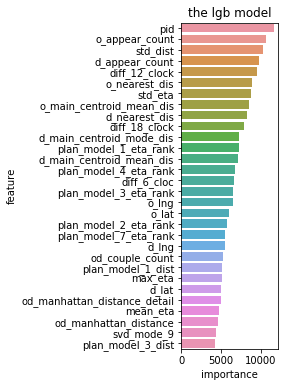

In [26]:
imp = pd.DataFrame()
imp['fea'] = feature
imp['imp'] = lgb_model.feature_importances_ 
imp = imp.sort_values('imp',ascending = False)
imp.to_csv(path + '/feature_import.csv')


#绘制特征重要度图
plt.figure(figsize=(8,6))
plt.subplot(142)
col_imp=pd.DataFrame({'feature':imp['fea'],'importance':imp['imp']}).sort_values(by='importance',ascending=False)
sns.barplot(x=col_imp['importance'][0:30],y=col_imp['feature'][0:30],orient='h')
plt.title('the lgb model')

## 结果分析
效果较差的转用规则

In [57]:
pred = lgb_model.predict(valid_x) 
df_analysis = pd.DataFrame()
df_analysis['sid']   = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred']  = pred
df_analysis['label'] = df_analysis['label'].astype(int)
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
dic_ = df_analysis['label'].value_counts(normalize = True)
#print('dic_:',dic_)

def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
#         print('dic_[i]:',dic_[i])        
#         print('yt:',yt)
#         print('yp:',yp)
        f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
        print(i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp))
    print(f_score)
get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])

0 0.08741402158137186 0.35813148788927335 0.8903225806451613 0.2241472658364916
1 0.1446172777181801 0.6872758988274058 0.6182547293174091 0.7736445947420094
2 0.313324288508866 0.9028254742675793 0.8523387890170826 0.959669704445899
3 0.04459834669022528 0.1355728854229154 0.4457593688362919 0.07994340290060134
4 0.024452577774973182 0.016331658291457284 0.30952380952380953 0.008387096774193548
5 0.0975736732504575 0.842221893928202 0.7753297973616211 0.9217461600646726
6 0.01989335520918786 0.16965352449223417 0.34382566585956414 0.11260904044409199
7 0.17792011106203068 0.7906450101514915 0.7063624947676852 0.8977655612697287
8 0.004559222565785322 0.26126126126126126 0.3741935483870968 0.20069204152249134
9 0.04993058623083233 0.5226601840597326 0.5801850424055512 0.4755134281200632
10 0.028475421215371995 0.5541355196527611 0.49060631938514093 0.6365650969529086
11 0.007241118192717865 0.45733788395904434 0.4785714285714286 0.43790849673202614
0.6926245775604085


对于以上验证的结果，   最后的列分布是这样的：  label标签号、 label所占据的验证集的比例、 当前label的F1得分、当前label的precision精度得分 等
  这里可以看出评价指标就是这样过来的，利用类别占据的数量比* 类别下的F1值得分。

## 线上提交

In [28]:
#线上提交
all_train_x              = data[data.req_time < '2018-12-01'][feature].reset_index(drop=True)
all_train_y              = data[data.req_time < '2018-12-01'].click_mode.reset_index(drop=True)
print(lgb_model.best_iteration_)
lgb_model.n_estimators   = lgb_model.best_iteration_
lgb_model.fit(all_train_x, all_train_y)   #best_iteration_  选择最好的一次迭代次数再次进行训练
print('fit over')
result                   = pd.DataFrame()
result['sid']            = data[test_index]['sid']
result['recommend_mode'] = lgb_model.predict(test_x)

probe_data = lgb_model.predict_proba(test_x)
result['recommend_mode'] = result['recommend_mode'].astype(int)
print(len(result))
print(result['recommend_mode'].value_counts())
result[['sid', 'recommend_mode']].to_csv(path + '/sub/baseline.csv', index=False)

319
fit over
94358
2     34063
7     22382
1     17817
5     10910
10     3340
0      2278
9      1907
3       650
11      405
6       320
8       225
4        61
Name: recommend_mode, dtype: int64


In [46]:
probe_data

array([[4.43260763e-02, 1.85283025e-05, 8.58066282e-01, ...,
        3.92591053e-02, 1.30527351e-05, 1.33036989e-05],
       [8.40223096e-02, 7.05635803e-01, 2.42565533e-05, ...,
        2.35655670e-05, 2.30085492e-05, 2.34509326e-05],
       [6.88909435e-02, 5.16146753e-02, 1.80032807e-05, ...,
        1.93327211e-05, 1.09486695e-01, 1.75041247e-05],
       ...,
       [4.52981189e-02, 2.74805508e-05, 1.89430537e-05, ...,
        1.89748096e-05, 1.83738195e-05, 1.87270914e-05],
       [1.37382256e-01, 3.39657755e-05, 2.49860330e-05, ...,
        5.33274179e-01, 2.25418077e-05, 2.29752171e-05],
       [6.45569653e-02, 8.54413199e-02, 1.84057696e-05, ...,
        1.83196086e-05, 1.78526807e-05, 2.88679811e-02]])

In [47]:

resule_probe=pd.DataFrame(probe_data,columns=['mode_'+str(i)+'_probe' for i in range(12)])
resule_probe['sid']= list(data[test_index]['sid'])
resule_probe.to_csv(path + '/sub/probe_file.csv', index=False)


In [48]:

path + '/sub/probe_file.csv'

'E:/Machine-learning/kdd_cup_2019/data//sub/probe_file.csv'

In [49]:
lgb_model.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [75]:
#统一的输出格式      这里使用了索引复制，但是经过复制之后，ignore_index=True好像真的不需要再加了
train_proba = pd.DataFrame()
train_proba['sid'] = data[train_index]['sid']
train_proba_temp=pd.DataFrame(lgb_model.predict_proba(train_x))
train_proba_temp.index=train_proba.index
train_proba = pd.concat([train_proba, train_proba_temp],axis=1)
train_proba['click_mode'] = data[train_index]['click_mode']
train_proba.to_csv('../data/prob_data/train_proba.csv',index=False)

valid_proba = pd.DataFrame()
valid_proba['sid'] = data[valid_index]['sid']
valid_proba_temp=pd.DataFrame(lgb_model.predict_proba(valid_x))
valid_proba_temp.index=valid_proba.index
valid_proba = pd.concat([valid_proba, valid_proba_temp],axis=1)
valid_proba['click_mode'] = lgb_model.predict(valid_x)
valid_proba.to_csv('../data/prob_data/valid_proba.csv',index=False)

test_proba = pd.DataFrame()
test_proba['sid'] = data[test_index]['sid']
test_proba_temp=pd.DataFrame(lgb_model.predict_proba(test_x))
test_proba_temp.index=test_proba.index
test_proba = pd.concat([test_proba, test_proba_temp],axis=1)
test_proba['click_mode'] = lgb_model.predict(test_x)
test_proba.to_csv('../data/prob_data/test_proba.csv',index=False)

In [59]:
 pd.DataFrame(lgb_model.predict_proba(valid_x))

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.067568,0.151279,0.000025,0.020949,0.036408,0.000022,0.000023,0.157812,0.000022,0.000022,0.565847,0.000022
1,0.027107,0.030816,0.806126,0.008002,0.010410,0.000011,0.000012,0.000013,0.021548,0.095931,0.000011,0.000011
2,0.063674,0.000046,0.000015,0.009352,0.000046,0.894941,0.031856,0.000015,0.000014,0.000013,0.000013,0.000013
3,0.055797,0.000029,0.728853,0.000457,0.000095,0.027263,0.052477,0.042667,0.000019,0.092305,0.000019,0.000019
4,0.060178,0.037981,0.777298,0.056343,0.012831,0.000017,0.000017,0.000020,0.000017,0.055266,0.000016,0.000017
5,0.030444,0.000014,0.953288,0.010629,0.005562,0.000009,0.000009,0.000010,0.000009,0.000009,0.000009,0.000009
6,0.088563,0.529273,0.105228,0.076620,0.034856,0.000021,0.000022,0.000025,0.000021,0.165328,0.000021,0.000021
7,0.222329,0.309043,0.000032,0.228053,0.104958,0.017088,0.118348,0.000034,0.000029,0.000029,0.000029,0.000029
8,0.113150,0.000033,0.000017,0.020418,0.000057,0.821466,0.044777,0.000018,0.000016,0.000016,0.000016,0.000016
9,0.038589,0.045290,0.329226,0.015092,0.011680,0.000019,0.008637,0.000019,0.000017,0.551397,0.000017,0.000017


In [78]:
lgb_model.predict_proba(valid_x)

94358

In [66]:
len(valid_proba)

118818

# 测试概率后处理的效果

In [219]:
def proba_process(valid_proba):
    val_pred_y = []
    for index,row in enumerate(valid_proba):
        if row[0] >= 0.3862:
            row[0] = 1
        if row[1] >= 0.4662:
            row[1] = 1
        if row[2] >= 0.4872:
            row[2] = 1
        if row[3] >= 0.2243:
            row[3] = 1
        if row[4] >= 0.1744:
            row[4] = 1
        if row[5] > 0.4096:
            row[5] = 1
        if row[6] > 0.1325:
            row[6] = 1
        if row[7] > 0.34940:
            row[7] = 1            
        if row[8] > 0.1585:
            row[8] = 1
        if row[9] >  0.2833:
            row[9] = 1  
        if row[10] > 0.2253:
            row[10] = 1
        if row[11] > 0.2983:
            row[11] = 1
        #print(row) 
        val_pred_y.append(np.argmax(row))
        #print(val_pred_y)
    return val_pred_y



pred = lgb_model.predict_proba(valid_x) 
df_analysis = pd.DataFrame()
df_analysis['sid']   = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred']  = proba_process(pred)
df_analysis['label'] = df_analysis['label'].astype(int)
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
dic_ = df_analysis['label'].value_counts(normalize = True)
#print('dic_:',dic_)

def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
#         print('dic_[i]:',dic_[i])        
#         print('yt:',yt)
#         print('yp:',yp)
        f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
        print(i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp))
    print(f_score)
get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])

0 0.08741402158137186 0.35840188014101054 0.9629044988161011 0.220176863382061
1 0.1446172777181801 0.6846451876019575 0.6426452292085367 0.7325188174975455
2 0.313324288508866 0.9031889848041663 0.8557908968003605 0.9561452092039676
3 0.04459834669022528 0.1914730661220322 0.3440366972477064 0.13264945171559958
4 0.024452577774973182 0.07999999999999999 0.23076923076923078 0.04838709677419355
5 0.0975736732504575 0.8488019411586291 0.799228901899186 0.9049312853678254
6 0.01989335520918786 0.21630347054075863 0.22021364009860311 0.21252973830293417
7 0.17792011106203068 0.7896684778329003 0.7101983002832861 0.8891647455222558
8 0.004559222565785322 0.31064572425828973 0.31338028169014087 0.3079584775086505
9 0.04993058623083233 0.5208861829866397 0.5604075691411936 0.48657187993680884
10 0.028475421215371995 0.5439493547601656 0.4852302345786273 0.618836565096953
11 0.007241118192717865 0.44366197183098594 0.48091603053435117 0.4117647058823529
0.6975753869348199
